<a href="https://colab.research.google.com/github/10Bruce10/Bruce/blob/master/Grammarly_data_challenge_(Haiyang_Zhang).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Grammarly data challenge

## Outline


* Part 1: Data Exploration
* Part 2: Daily Active User Analysis
* Part 3: Cohort Analysis
* Part 4: Traffic Source Analysis
* Part 5: Future Work




# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [ ]:
#import neccessary libraries
import numpy as np
import pandas as pd
import sklearn as sl
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import pandas_profiling as pp 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from scipy.stats import zscore
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import kurtosis

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install -U -q PyDrive
!pip install category_encoders

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/open?id=1oEL-PjnIIg0UYg_YZSXPcV9ShlDWkZgF'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('grammarly_data_exercise.json')  

In [ ]:
#understand the data
df_original = pd.read_json('grammarly_data_exercise.json')
df1 = df_original.copy()

In [ ]:
df1.head()

,date,timestamp,uid,isFirst,utmSource
0,2016-02-29,2016-02-29 08:00:01.255,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
1,2016-02-29,2016-02-29 08:00:01.556,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
2,2016-02-29,2016-02-29 08:00:01.770,75121338,False,program
3,2016-02-29,2016-02-29 08:00:03.129,11l0tD2wFPFO,False,None
4,2016-02-29,2016-02-29 08:00:03.610,56429432,False,None


In [ ]:
def initial_analysis(df):
    """
    Given a dataframe produces a simple report on initial data analytics
    Params:
        - df 
    Returns:
        - Shape of dataframe records and columns
        - Columns and data types
    """
    print('Report of Initial Data Analysis:\n')
    print("Num of entries: " + str(df1.shape[0])) 
    print("Num of features: " + str(df1.shape[1])) 
    print(f'Features and Data Types: \n {df.dtypes}')

initial_analysis(df_original)

Report of Initial Data Analysis:

Num of entries: 4823567
Num of features: 5
Features and Data Types: 
 date         datetime64[ns]
timestamp    datetime64[ns]
uid                  object
isFirst                bool
utmSource            object
dtype: object


In [ ]:
#data exploration and statistical summary by pandas profilling
profile = pp.ProfileReport(df1, title='Pandas Profiling Report', explorative=True)

In [ ]:
#data exploration and statistical summary by pandas profilling
profile

Based on brief data exploration, dataset has 2 datetime feature: 'date' and 'timestamp'; 1 Boolean feature 'isFirst'; The rest features are categorical features. And a large proportion of missing value was observed in feature 'utmSource'.

### Part 1.2: Data cleaning

#### Part 1.2.1: Missing value and duplications



In [ ]:
#data cleaning#1: missing value --- check the the percentage of missing records per column
def percent_missing(df):
    """
    Given a dataframe it calculates the percentage of missing records per column
    Params:
        - df
    Returns:
        - Dictionary of column name and percentage of missing records
    """
    col=list(df1.columns)
    perc=[round(df[c].isna().mean()*100,2) for c in col]
    miss_dict=dict(zip(col,perc))
    return miss_dict

percent_missing(df1)

{'date': 0.0, 'isFirst': 0.0, 'timestamp': 0.0, 'uid': 0.0, 'utmSource': 34.71}

In [ ]:
#data cleaning#2: logical mistake --- duplication
df1_dup = df1[df1.duplicated()]
print("Number of identically duplicated rows : " + str(len(df1_dup)))

df1_remove = df1[~df1.duplicated()]
print("Number of remaining rows: " + str(len(df1_remove)))

Number of identically duplicated rows : 12979
Number of remaining rows: 4810588


#### Part 1.2.2: Inconsistent time zone between 'date' and 'timestamp'

In [ ]:
#inconsistencies were oberseved between 'date' and 'timestamp'
df1_remove.tail()

,date,timestamp,uid,isFirst,utmSource
4823561,2016-02-06,2016-02-07 07:59:55.524,Owrk6WHGQ0jS,False,None
4823562,2016-02-06,2016-02-07 07:59:55.890,QLECxJO2VaIZ,False,Biznesowe+Rewolucje
4823563,2016-02-06,2016-02-07 07:59:57.185,58056634,False,shmoop_left
4823564,2016-02-06,2016-02-07 07:59:57.629,56936469,False,None
4823565,2016-02-06,2016-02-07 07:59:59.555,63953998,False,Biznesowe+Rewolucje


The feature 'timestamp' was generated based on GMT(Greenwich Mean Time), which is 8 hours ahead of feature 'date'(Pacific Time). So there are inconsistencies between 'date' and 'timestamp' when 'timestamp' is between 00:00 - 08:00, there will be one-day difference between them. Due to this inconsistency, I convert the original 'timestamp' from GMT to PT. 

In [ ]:
#convert the original 'timestamp' from GMT to PT
df2 = df1_remove.copy()
df2['timestamp'] = df2['timestamp'].dt.tz_localize("GMT").dt.tz_convert('America/Los_Angeles')

In [ ]:
df2.tail()

,date,timestamp,uid,isFirst,utmSource
4823561,2016-02-06,2016-02-06 23:59:55.524000-08:00,Owrk6WHGQ0jS,False,None
4823562,2016-02-06,2016-02-06 23:59:55.890000-08:00,QLECxJO2VaIZ,False,Biznesowe+Rewolucje
4823563,2016-02-06,2016-02-06 23:59:57.185000-08:00,58056634,False,shmoop_left
4823564,2016-02-06,2016-02-06 23:59:57.629000-08:00,56936469,False,None
4823565,2016-02-06,2016-02-06 23:59:59.555000-08:00,63953998,False,Biznesowe+Rewolucje


# Part 1: Daily Active User Analysis

The defination of daily active user (DAU) is that a customer pinged at least once on a given day.

In [ ]:
# DAU of all users
dau_all = pd.DataFrame(df2.groupby(["date", 'uid'])['timestamp'].nunique().sort_values(ascending=False).rename("action_counts").reset_index())
dau_all.loc[dau_all.action_counts > 0,'Activity']='Active'
dau_all.loc[dau_all.action_counts == 0,'Activity']='Passive'

dau_all = dau_all[(dau_all.Activity == 'Active')]
dau_all_plot = dau_all.groupby(['date'])['uid'].nunique().sort_values(ascending=False).rename("total_DAU").reset_index()

(0.0, 150000.0)

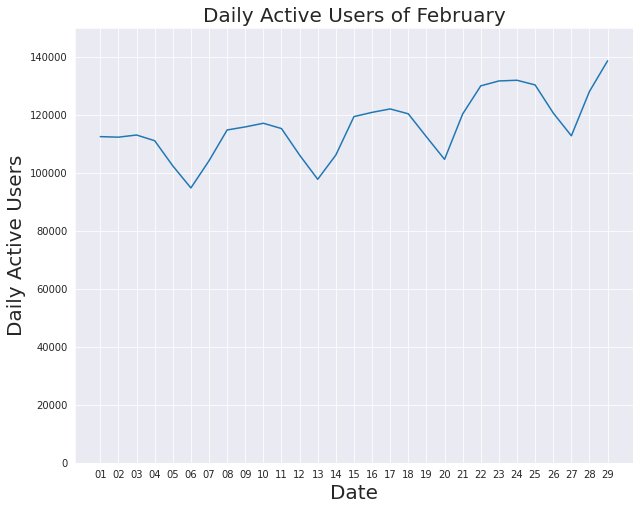

In [ ]:
# DAU of all users on each date of Feb
dau_all_plot['Date'] = dau_all_plot.date.apply(lambda x: x.strftime('%d'))
f,ax = plt.subplots(figsize=(10,8))
fig = sns.lineplot(x="Date", y="total_DAU", data=dau_all_plot)
sns.set_color_codes()
sns.set_style("darkgrid")
ax.set_xlabel('Date', fontsize= 20)
ax.set_ylabel('Daily Active Users', fontsize= 20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Daily Active Users of February',fontsize= 20)
#plt.xticks(rotation=45)
ax.set_ylim(bottom = 0, top = 150000)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

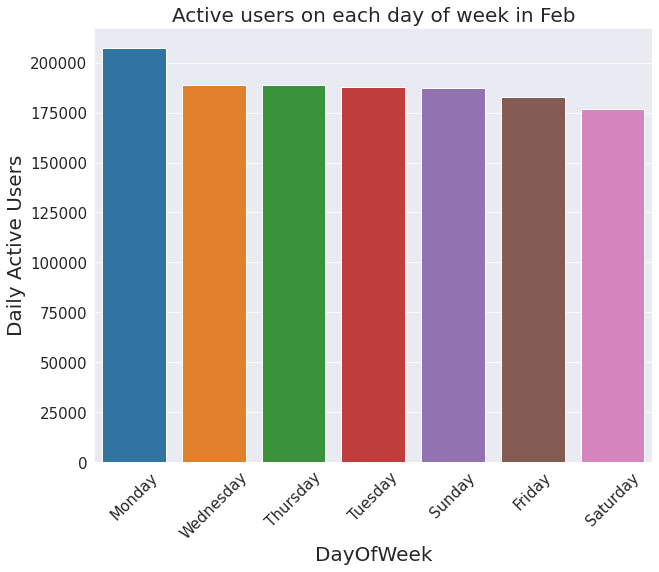

In [ ]:
#Active users on each day of week in Feb
dau_all['DayOfWeek'] = dau_all.date.apply(lambda x: x.strftime('%A'))
dau_all_week_plot = dau_all.groupby(['DayOfWeek'])['uid'].nunique().sort_values(ascending=False).rename("total_week_DAU").reset_index()

f,ax = plt.subplots(figsize=(10,8))
fig = sns.barplot(x="DayOfWeek", y="total_week_DAU", data=dau_all_week_plot)
sns.set_color_codes()
sns.set_style("darkgrid")
ax.set_xlabel('DayOfWeek', fontsize= 20)
ax.set_ylabel('Daily Active Users', fontsize= 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Active users on each day of week in Feb',fontsize= 20)
plt.xticks(rotation=45)
#ax.set_ylim(bottom = 0, top = 150000)

##To avoid using vanity metric of DAU, the normalized DAU of returning users was used.

In [ ]:
df2_new = df2[(df2.isFirst == True)]
print("Number of new Feb users : " + str(df2_new.shape[0]))

Number of new Feb users : 86643


(0.0, 150000.0)

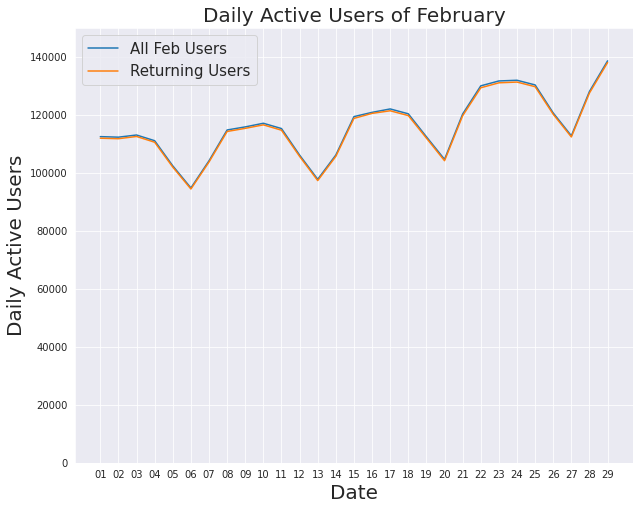

In [ ]:
#DAU of returning users
df2_re = df2[(df2.isFirst == False)]
dau_re_plot = df2_re.groupby(['date'])['uid'].nunique().sort_values(ascending=False).rename("total_DAU").reset_index()
dau_re_plot['Date'] = dau_re_plot.date.apply(lambda x: x.strftime('%d'))

#DAU of all type of users in Feb 
f,ax = plt.subplots(figsize=(10,8))
fig= sns.lineplot(x="Date", y="total_DAU", data=dau_all_plot, label = 'All Feb Users')
fig= sns.lineplot(x = "Date", y="total_DAU", data = dau_re_plot, label = 'Returning Users')
sns.set_style("darkgrid")
ax.set_xlabel('Date', fontsize= 20)
ax.set_ylabel('Daily Active Users', fontsize= 20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Daily Active Users of February',fontsize= 20)
plt.legend(fontsize=15)
#plt.xticks(rotation=45)
ax.set_ylim(bottom = 0, top = 150000)

Discoveries based on daily active user analysis:

1.   Overall, there is an increasing trend of daily active users on Feb.
2.   Based on further analysis within weeks, Monday shows the most active users, which matches the impression of the beginning of a week. Saturday has the least active users in a week.


# Part 2: Cohort analysis 

###Part 2.1: retention curve

In [ ]:
#Create an 'active_date' column based on the 'date' 
df3 = df2.copy()
df3 = df3[(df3['isFirst']== True)]
df3['active_date'] = df3.date.apply(lambda x: x.strftime('%d'))

#Determine the user's cohort group (based on their first active date)
df3.set_index('uid', inplace=True)
df3['CohortGroup'] = df3.groupby(level=0)['date'].min().apply(lambda x: x.strftime('%d'))
df3.reset_index(inplace=True)

In [ ]:
#Rollup data by CohortGroup & active_date
grouped = df3.groupby(['CohortGroup', 'active_date'])

#Count the unique users per Group
cohorts = grouped.agg({'uid': pd.Series.nunique})

#make the column names more meaningful
cohorts.rename(columns={'uid': 'TotalUsers'}, inplace=True)

In [ ]:
#Creat the 'cohort_period' for each CohortGroup
def cohort_period(df):
    """  Creates a 'CohortPeriod' column, which is the Nth date based on the user's first activity.  """
    df['cohort_period'] = np.arange(len(df)) + 1
    return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()


,,TotalUsers,cohort_period
CohortGroup,active_date,,
01,01,3071,1
02,02,2966,1
03,03,2876,1
04,04,2735,1
05,05,2240,1


In [ ]:
#user Retention by Cohort Group 
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'cohort_period'], inplace=True)

cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()

Text(0.5, 1.0, 'Active users of each cohortGroup')

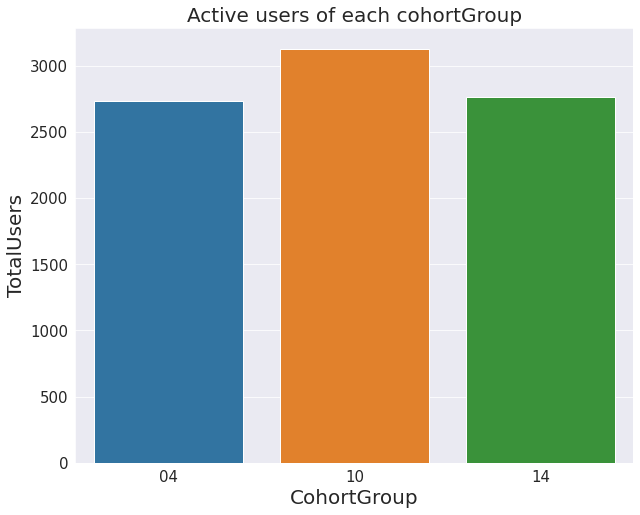

In [ ]:
#The number of users from each cohort of Feb 4th, Feb 10th, and Feb 14th.
co_plot = cohort_group_size.reset_index()
cohort_group_size_plot_three = co_plot[(co_plot.CohortGroup == '04')|(co_plot.CohortGroup == '10')|(co_plot.CohortGroup == '14')]

f,ax = plt.subplots(figsize=(10,8))
fig = sns.barplot(x="CohortGroup", y="TotalUsers", data=cohort_group_size_plot_three)
sns.set_color_codes()
sns.set_style("darkgrid")
ax.set_xlabel('CohortGroup', fontsize= 20)
ax.set_ylabel('TotalUsers', fontsize= 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Active users of each cohortGroup',fontsize= 20)
#plt.xticks(rotation=45)
#ax.set_ylim(bottom = 0, top = 150000)

In [ ]:
#User retention
cohorts['TotalUsers'].unstack(0).head()
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
cohort_period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
2,0.809,0.640,0.554,0.501,0.475,0.518,0.540,0.574,0.559,0.562,0.533,0.486,0.568,0.578,0.610,0.511,0.594,0.567,0.534,0.601,0.635,0.628,0.634,0.625,0.566,0.542,0.616,0.622,nan
3,0.795,0.606,0.475,0.427,0.455,0.461,0.494,0.516,0.490,0.463,0.435,0.461,0.513,0.520,0.537,0.434,0.488,0.474,0.505,0.541,0.577,0.568,0.561,0.519,0.479,0.523,0.554,nan,nan
4,0.764,0.528,0.426,0.451,0.465,0.417,0.474,0.465,0.406,0.403,0.441,0.476,0.476,0.481,0.510,0.368,0.425,0.509,0.506,0.515,0.546,0.526,0.481,0.461,0.496,0.526,nan,nan,nan
5,0.696,0.490,0.457,0.467,0.434,0.410,0.441,0.425,0.354,0.425,0.476,0.447,0.460,0.449,0.456,0.337,0.469,0.507,0.488,0.496,0.519,0.460,0.438,0.499,0.526,nan,nan,nan,nan
6,0.628,0.534,0.481,0.452,0.430,0.395,0.391,0.374,0.388,0.466,0.469,0.435,0.437,0.406,0.426,0.352,0.497,0.495,0.461,0.478,0.459,0.413,0.480,0.515,nan,nan,nan,nan,nan
7,0.678,0.564,0.477,0.454,0.414,0.372,0.377,0.385,0.424,0.453,0.452,0.413,0.415,0.405,0.464,0.365,0.479,0.485,0.443,0.448,0.446,0.451,0.503,nan,nan,nan,nan,nan,nan
8,0.743,0.580,0.480,0.445,0.384,0.382,0.410,0.437,0.419,0.456,0.437,0.397,0.414,0.445,0.468,0.370,0.473,0.469,0.429,0.452,0.500,0.491,nan,nan,nan,nan,nan,nan,nan
9,0.735,0.561,0.450,0.380,0.363,0.383,0.431,0.428,0.404,0.414,0.387,0.357,0.428,0.436,0.458,0.334,0.449,0.424,0.381,0.458,0.488,nan,nan,nan,nan,nan,nan,nan,nan


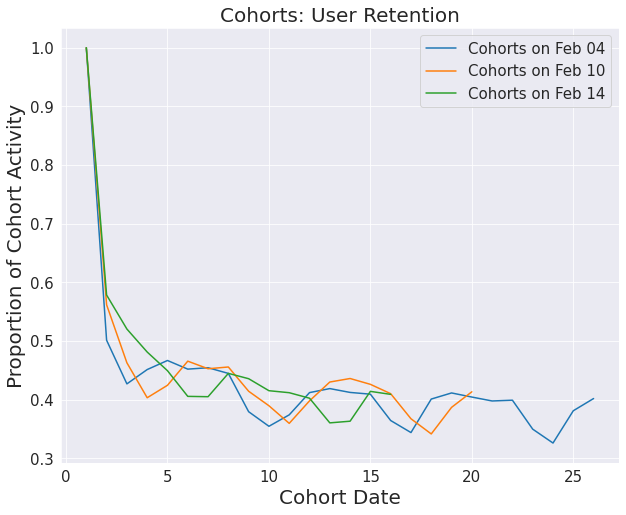

In [ ]:
#User retention curves of Feb 4th, Feb 10th, and Feb 14th.
f,ax = plt.subplots(figsize=(10,8))
plt.plot(user_retention[['04']], label='Cohorts on Feb 04')
plt.plot(user_retention[['10']], label='Cohorts on Feb 10')
plt.plot(user_retention[['14']], label='Cohorts on Feb 14')
sns.set_style("darkgrid")
plt.xlabel('Cohort Date', fontsize= 20)
plt.ylabel('Proportion of Cohort Activity', fontsize= 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Cohorts: User Retention',fontsize= 20)
plt.legend(fontsize=15)

Text(0.5, 1.0, 'User Retention')

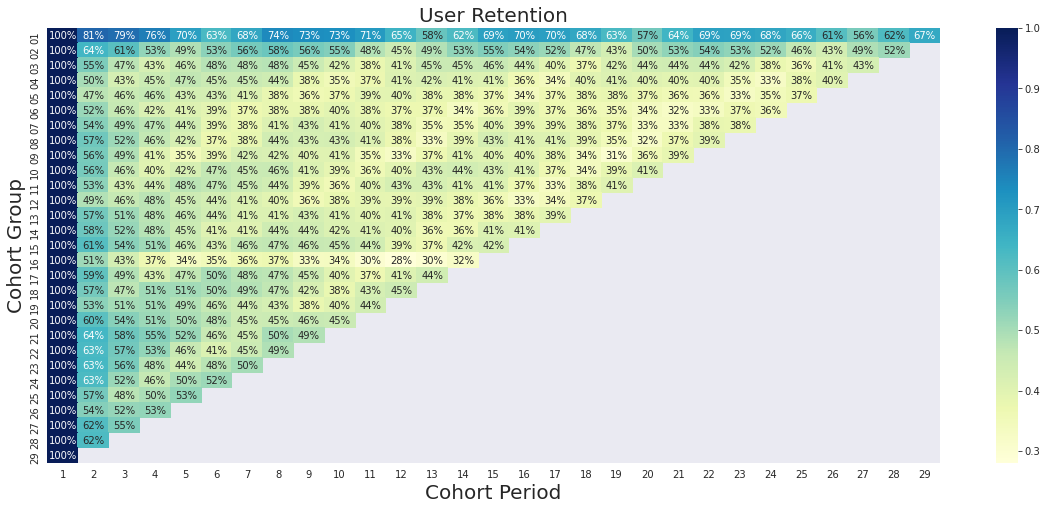

In [ ]:
#User retention percentage of entire Feb users
f,ax = plt.subplots(figsize=(20, 8))
fig = sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%', cmap = "YlGnBu")
sns.set_color_codes()
sns.set_style("darkgrid")
ax.set_xlabel('Cohort Period', fontsize= 20)
ax.set_ylabel('Cohort Group', fontsize= 20)
plt.title('User Retention',fontsize= 20)

###Part 2.2: User churn analysis on the Feb new users only

Identify churn customers and determine its churn time. The definitaion of churn time is the time difference (min) between the first and last activities.





In [ ]:
#Churn is defined by time of last user activity.
from datetime import datetime as dt
df4 = df2.copy()
df4 = df4[(df4.isFirst == True)]
last_trans_first = df4.groupby('uid')['timestamp'].max().reset_index()
start_trans_first = df4.groupby('uid')['timestamp'].first().reset_index()
last_trans_first['noaction_period_minutes'] = (last_trans_first['timestamp'] - start_trans_first['timestamp']) / pd.Timedelta(minutes=1)

In [ ]:
#The churn time (calculated based on the first and last activities)
display(last_trans_first['noaction_period_minutes'].unique())

array([  0.        ,   3.80245   ,  11.4181    ,  11.68871667,
         6.0929    ,   7.74938333,   3.21535   ,   9.80515   ,
         2.98585   ,  11.64276667,   5.86225   ,   9.6865    ,
         7.40983333, 112.24921667,  16.27001667,  18.0243    ,
        39.79013333,   1.68003333,  11.92935   , 223.45363333,
        30.09861667,   2.42628333,  17.42293333,   9.50961667,
         2.63155   ,  24.71516667,  23.6429    ,  61.41815   ,
         1.98111667,  79.01645   ,  10.85316667,  15.77266667,
        17.75635   ,  73.93838333,  14.0642    ,  11.19721667,
        99.16933333,   2.76666667])

In [ ]:
#Over 99.9% first users (Feb new users) churn after their first usage.
last_trans_first['noaction_period_minutes'].value_counts(10).head()

0.000    0.999
7.410    0.000
11.689   0.000
5.862    0.000
39.790   0.000
Name: noaction_period_minutes, dtype: float64

Text(0.5, 1.0, 'Churn time of Feb new users')

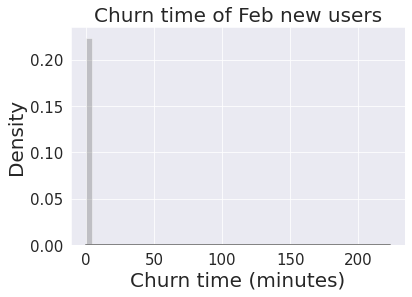

In [ ]:
#Over 99.9% first users (Feb new users) churn after their first usage.
f,ax = plt.subplots()
fig = sns.distplot(last_trans_first['noaction_period_minutes'], color = 'gray')
sns.set_color_codes()
sns.set_style("darkgrid")
ax.set_xlabel('Churn time (minutes)', fontsize= 20)
ax.set_ylabel('Density', fontsize= 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Churn time of Feb new users',fontsize= 20)


Discoveries based on cohort analyais:

1.   A significant user churn was observed after their first day of using grammarly (avg 42.5% drop).
2.   The number of users of cohorts Feb 4th, Feb 10th, and Feb 14th are: 2735, 3129 and 2761 respectively.
3.   Over 99.9% first users (Feb new users) churn after the first time using Grammarly.



# Part 3: Traffic Source Analysis 

Determine if there are any differences in usage based on where the users came from. From which traffic source does the app get its best users? Its worst users?

###Part 3.1: Understand the original source type

In [ ]:
#Feture 'utmSource' has 34.71% missing values. So I define them with a new source name as 'Missing'.
df8 = df2.copy()
df8["utmSource"] = df8["utmSource"].fillna('Missing')

###Part 3.2: Define the "best" and the "worst" users

With limited information, generally speaking, active users (ping more than 1 times) and registered users (user id with "pure numeric") tend to be loyal customers.

In [ ]:
#Define registered users based on userID
df8['Registration'] = df8['uid'].apply(lambda x: 'registered' if x.isnumeric() else 'guest')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]), <a list of 53 Text major ticklabel objects>)

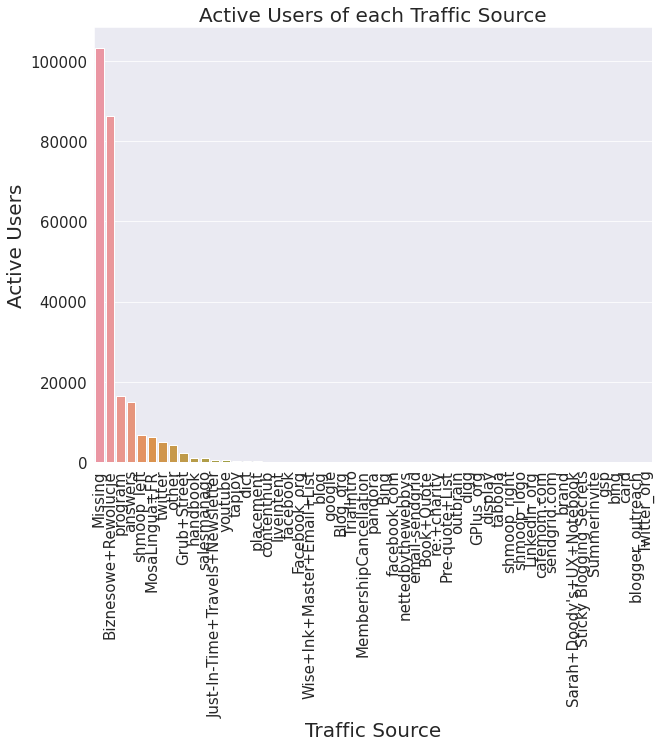

In [ ]:
#Active users on each traffic source
dau_source_all_plot = df8.groupby(['utmSource'])['uid'].nunique().sort_values(ascending=False).rename("total_DAU").reset_index()

f,ax = plt.subplots(figsize=(10,8))
fig = sns.barplot(x = "utmSource", y="total_DAU", data = dau_source_all_plot)
sns.set_color_codes()
sns.set_style("darkgrid")
ax.set_xlabel('Traffic Source', fontsize= 20)
ax.set_ylabel('Active Users', fontsize= 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Active Users of each Traffic Source',fontsize= 20)
plt.xticks(rotation=90)
#ax.set_ylim(bottom = 0, top = 150000)


In [ ]:
#Look for the most representative traffic sources
cumulated_dau = np.cumsum(dau_source_all_plot.total_DAU/dau_source_all_plot.total_DAU.sum())
cumulated_dau.head(12)

0    0.411
1    0.755
2    0.821
3    0.880
4    0.908
5    0.933
6    0.954
7    0.971
8    0.981
9    0.986
10   0.990
11   0.992
Name: total_DAU, dtype: float64

Text(0.5, 1.0, 'The most representative Traffic Sources')

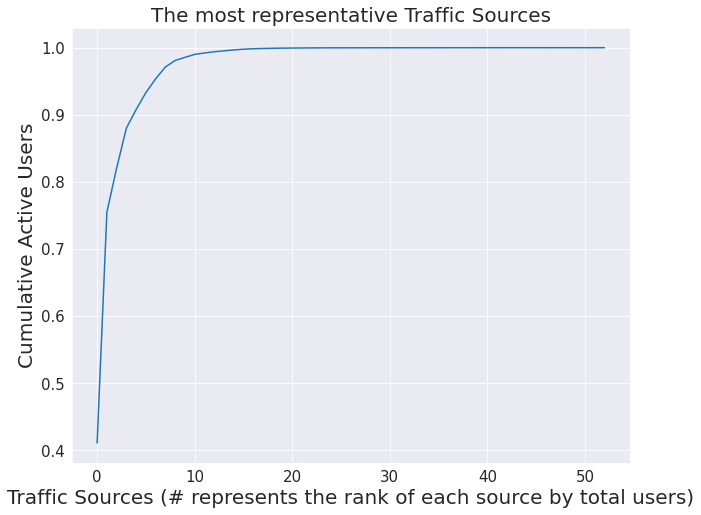

In [ ]:
#Top 10 the most representative traffic sources explain 99% active users!
f,ax = plt.subplots(figsize=(10,8))
plt.plot(cumulated_dau)
sns.set_style("darkgrid")
ax.set_xlabel('Traffic Sources (# represents the rank of each source by total users)', fontsize= 20)
ax.set_ylabel('Cumulative Active Users', fontsize= 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('The most representative Traffic Sources',fontsize= 20)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]), <a list of 53 Text major ticklabel objects>)

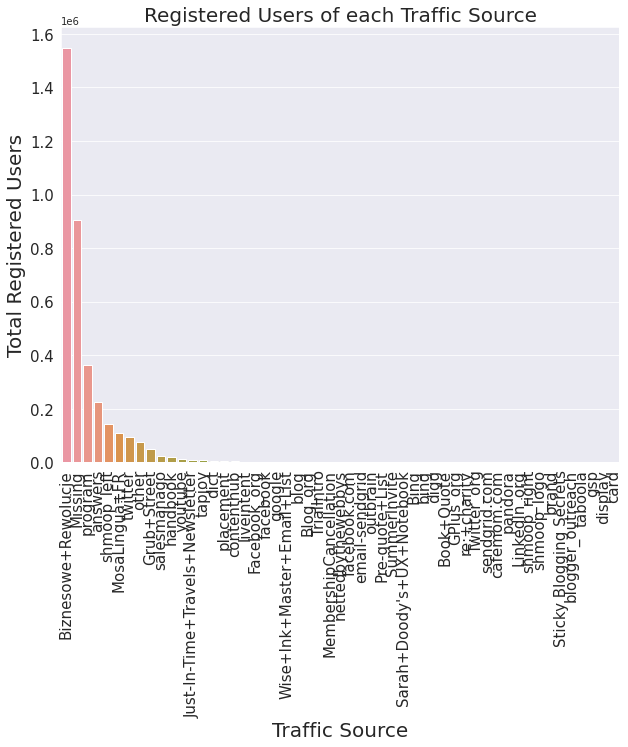

In [ ]:
#Registered users on each traffic source
df_reg = df8[(df8['Registration'] == 'registered')]
df_reg = pd.DataFrame(df_reg.groupby(["utmSource"])['Registration'].size().sort_values(ascending=False).rename("total registered").reset_index())

f,ax = plt.subplots(figsize=(10,8))
fig= sns.barplot(x = "utmSource", y="total registered", data = df_reg)
sns.set_color_codes()
sns.set_style("darkgrid")
ax.set_xlabel('Traffic Source', fontsize= 20)
ax.set_ylabel('Total Registered Users', fontsize= 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Registered Users of each Traffic Source',fontsize= 20)
plt.xticks(rotation=90)


Based on the data exploration on traffic sources, I noticed the 52 categories are not well defined. 


1.   redundant categories: 'facebook', 'Facebook_org', 'facebook.com' etc.
2.   ambiguous sources: 'dict', 'display', 'brand' etc.

3.   'Missing' (undefined traffic source) accounts over 40% of users.



###Part 3.3: Define new traffic sources



1.  Combine same traffic sources
2.   Remove undefined traffic source (since it will not help to illustrate insightful information)
3.   Define new traffic categories based on Grammarly main targets customers (Email, Documents and Social media)


In [ ]:
#Generate new traffic categories due to Grammarly main users dissection
source_dict = {'Biznesowe+Rewolucje': 'Blogging', 'program': 'Program', 'answers': 'Online_learning', "shmoop_left": 'Online_learning',
               'shmoop_left': 'Online_learning', 'twitter': 'Social_media', 'MosaLingua+FR': 'Online_learning', 'other': 'Ambiguous',
               'Grub+Street': 'Blogging', 'salesmanago': 'Business_platform', 'handbook': 'Online_learning', 'youtube': 'Social_media',
               'Just-In-Time+Travels+Newsletter': 'Blogging', 'tapjoy': 'Business_platform', 'contenthub': 'Blogging', 'dict': 'Ambiguous',
              'placement': 'Business_platform', 'Facebook_org': 'Social_media', 'blog': 'Blogging', 'liveintent': 'Business_platform',
               'facebook': 'Social_media', 'google': 'Social_media', 'Wise+Ink+Master+Email+List': 'Email&Message', 'Blog_org': 'Blogging',
               'TrialIntro': 'Ambiguous', 'MembershipCancellation': 'Ambiguous', 'nettedbythewebbys': 'Ambiguous', 'facebook.com': 'Social_media',
              'email-sendgrid': 'Email&Message', 'Bing': 'Social_media', 'outbrain': 'Business_platform', 'Pre-quote+List': 'Ambiguous', 
               'SummerInvite': 'Ambiguous', "Sarah+Doody's+UX+Notebook": 'Ambiguous', 'pandora': 'Social_media', 'bing': 'Social_media',
               'digg': 'Blogging', 'Book+Quote': 'Online_learning', 'GPlus_org': 'Social_media', 're:+charity': 'Business_platform',
               'Twitter_org': 'Social_media', 'sendgrid.com': 'Email&Message', 'cafemom.com': 'Blogging', 'LinkedIn_org': 'Social_media',
                "shmoop_right": 'Online_learning', "shmoop_logo": 'Online_learning', 'brand': 'Ambiguous', 'Sticky Blogging Secrets': 'Blogging',
               'blogger_outreach': 'Blogging', 'taboola': 'Blogging', 'gsp': 'Ambiguous', 'card': 'Ambiguous', 'display': 'Ambiguous', 'Missing': 'Missing' }

df8['newSource'] = df8['utmSource'].map(source_dict)

In [ ]:
#Remove 'Missing' category 
df8 = df8[df8['utmSource'] != 'Missing']

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

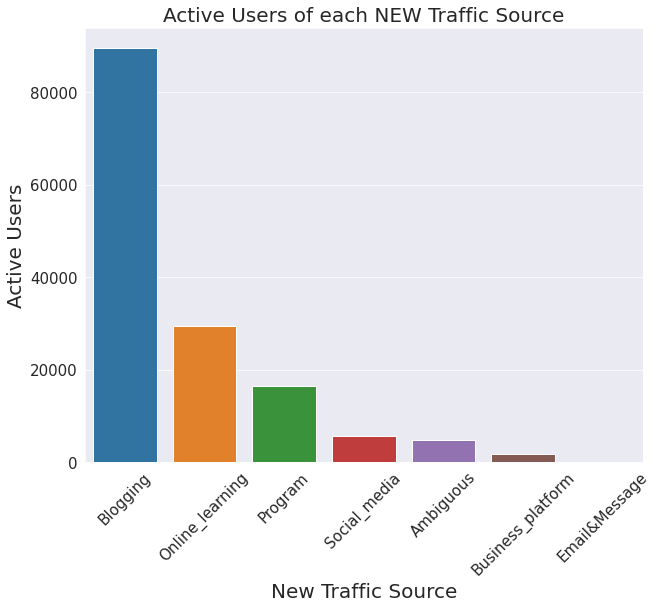

In [ ]:
#Daily active users on each NEW traffic source
df9 = df8.copy()
dau_new_source_plot = df9.groupby(['newSource'])['uid'].nunique().sort_values(ascending=False).rename("total_DAU").reset_index()

f,ax = plt.subplots(figsize=(10,8))
fig= sns.barplot(x = "newSource", y="total_DAU", data = dau_new_source_plot)
sns.set_color_codes()
sns.set_style("darkgrid")
ax.set_xlabel('New Traffic Source', fontsize= 20)
ax.set_ylabel('Active Users', fontsize= 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Active Users of each NEW Traffic Source',fontsize= 20)
plt.xticks(rotation=45)

In [ ]:
#Blogging and Online learning traffic sources explain over 80% DAU
cumulated_dau_new = np.cumsum(dau_new_source_plot.total_DAU/dau_new_source_plot.total_DAU.sum())
cumulated_dau_new.head(8)

0   0.605
1   0.804
2   0.916
3   0.955
4   0.987
5   1.000
6   1.000
Name: total_DAU, dtype: float64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

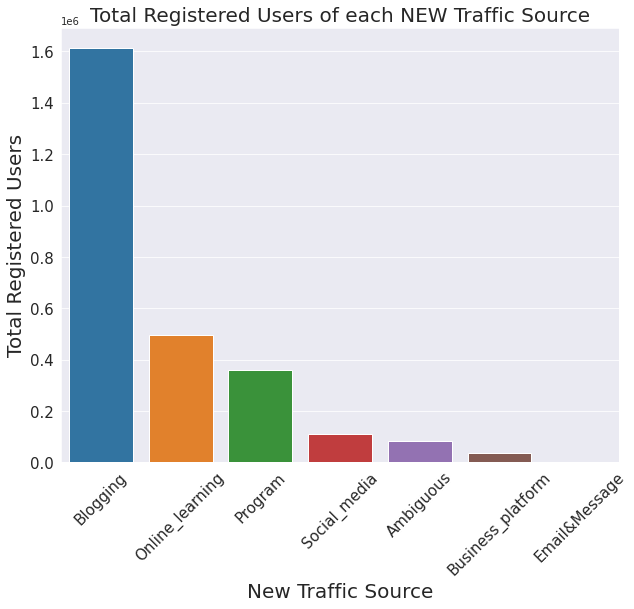

In [ ]:
#Registered users on each NEW traffic source
df_reg_new = df8[(df8['Registration'] == 'registered')]
df_reg_new = pd.DataFrame(df_reg_new.groupby(["newSource"])['Registration'].size().sort_values(ascending=False).rename("total registered").reset_index())

f,ax = plt.subplots(figsize=(10,8))
fig= sns.barplot(x = "newSource", y="total registered", data = df_reg_new)
sns.set_color_codes()
sns.set_style("darkgrid")
ax.set_xlabel('New Traffic Source', fontsize= 20)
ax.set_ylabel('Total Registered Users', fontsize= 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Total Registered Users of each NEW Traffic Source',fontsize= 20)
plt.xticks(rotation=45)


###Part 3.4: Active users distribution analysis on different traffic sources and dates

In [ ]:
#Total #DAU/New Traffic Source/ Date
df10 = df8.copy()
df10['date'] = df10.date.apply(lambda x: x.strftime('%d'))
newsource_plot = df10.groupby(['newSource', 'date'])['uid'].nunique().sort_values(ascending=False).rename("total_DAU")

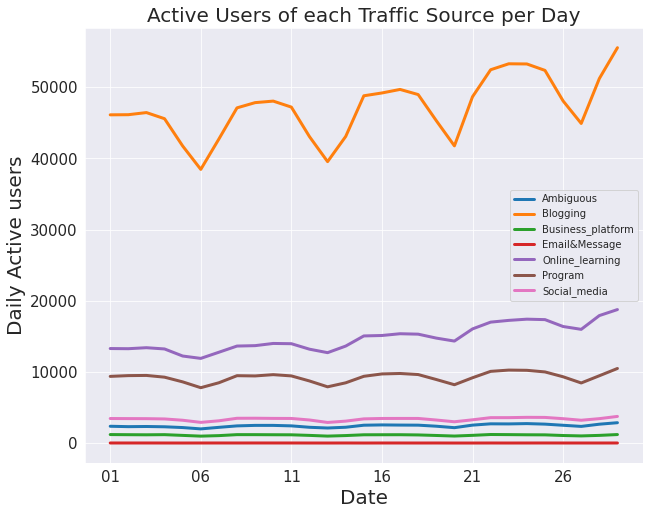

In [ ]:
#Total #DAU/New Traffic Source/ Date
#newsource_plot.unstack().T
fig, ax = plt.subplots(figsize=(10,8))
newsource_plot.unstack().T.plot(ax=ax, kind='line',linewidth=3)
sns.set_style("darkgrid")
plt.xlabel('Date', fontsize= 20)
plt.ylabel('Daily Active users', fontsize= 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Active Users of each Traffic Source per Day',fontsize= 20)
plt.legend(fontsize=10)

Based on the traffic source analysis, the results indicate that:


1.   The 'Blogging' traffic source has the most loyal customers in terms of daily active user and registration. (The origial traffic source is called 'Biznesowe+Rewolucje'); The 'Email&Message' traffic source has the least amount of active users and few registered users.
2.   Blogging and Online learning traffic sources explain over 80% loyal customers.
3.   'Missing' (undefined traffic source) accounts over 40% of users.
4.   Based on the daily activity analysis on each traffic source, 'Blogging' source has the most dynamic changes and 'Program'&'Online_learning' have relatively stable activity level. (which mataches our impressions with blog and online-learning. Blogging is a story-sharing habit but online-learning has a daily(or periodic) routine)


# Part 4: Futhur Work



1. Churn prediction: Given the majority of churn happens within the first several minutes after the initial login, it is worth studying the user behavior within this churn time period. If more features can be provided, a churn model can be developed to predict Day 0 Churn and identify behaviors of churn users. (If user behavior features like purchase membership record, profile update, spelling mistake correction etc. can be provided)

2. Better define of the "Best" the "Worst" users: Considering the limited features being provided, the "Best" users were only defined by activity and registration record. Except a startup company, revenue is always one of the top 3 most important features. The conversion rate, user lifetime value, average revenue/user etc. can be considered as more appropriate metrics to focus on.

